In [114]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as transforms # Use updated transforms API
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
from pycocotools import mask as coco_mask

import albumentations as A
from albumentations.pytorch import ToTensorV2


In [115]:
train_img_folder = './data/OSCD/coco_carton/oneclass_carton/images/train2017'
train_ann_file = './data/OSCD/coco_carton/oneclass_carton/annotations/instances_train2017.json'

val_img_folder = "./data/OSCD/coco_carton/oneclass_carton/images/val2017"
val_ann_file = "./data/OSCD/coco_carton/oneclass_carton/annotations/instances_val2017.json"

In [116]:
transform_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.1),
    A.GaussNoise(p=0.1),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['category_ids'],
                            min_visibility=0.1))


/workspace/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [117]:
class AlbumentationsCocoTransforms:
    def __init__(self, transform=None):
            self.transform = transform

    def __call__(self, img_pil, target):
        # Convert PIL image to NumPy array (H, W, C)
        img_np = np.array(img_pil)
        img_height, img_width, _ = img_np.shape

        # Prepare annotations for Albumentations
        masks_np = []
        bboxes_np = []
        category_ids = []

        if target: # If there are annotations
            for ann in target:
                # 1. Decode Segmentation Mask to NumPy array (H, W)
                segmentation = ann['segmentation']
                binary_mask = None
                if isinstance(segmentation, list): # Polygon format
                    rles = coco_mask.frPyObjects(segmentation, img_height, img_width)
                    decoded_mask = coco_mask.decode(rles)
                    if len(decoded_mask.shape) == 3: # Merge if multiple polygons
                            binary_mask = np.sum(decoded_mask, axis=2)
                    else:
                            binary_mask = decoded_mask
                    binary_mask = np.clip(binary_mask, 0, 1).astype(np.uint8) # Use uint8 for masks
                elif isinstance(segmentation, dict) and 'counts' in segmentation and 'size' in segmentation: # RLE format
                    binary_mask = coco_mask.decode(segmentation).astype(np.uint8) # Use uint8 for masks

                # 2. Extract Bounding Box (COCO format)
                bbox = ann.get('bbox', None) # [x_min, y_min, width, height]

                # 3. Extract Category ID
                cat_id = ann.get('category_id', None) # Use a default or skip if missing?

                # Add data only if mask, bbox, and cat_id are valid
                if binary_mask is not None and bbox is not None and cat_id is not None:
                    masks_np.append(binary_mask)
                    bboxes_np.append(bbox)
                    category_ids.append(cat_id)
                else:
                    print(f"  Skipping annotation due to missing mask/bbox/category_id: {ann.get('id', 'N/A')}")


        # Apply Albumentations transformations
        if self.transform and masks_np: # Only apply if transform exists and there are valid annotations
            try:
                augmented = self.transform(image=img_np,
                                            masks=masks_np,
                                            bboxes=bboxes_np,
                                            category_ids=category_ids)
                # Return augmented data (still NumPy arrays for image/masks)
                # Bboxes might be list of tuples/lists
                return augmented['image'], augmented['masks'], augmented['bboxes'], augmented['category_ids']
            except Exception as e:
                print(f"Error during Albumentations transform: {e}. Returning original data.")
                # Fallback: return original image and empty lists for annotations
                return img_np, [], [], []
        else:
            # No transform or no valid annotations, return original image (as NumPy) and empty lists
            return img_np, [], [], []

In [118]:
dataset = CocoDetection(root=train_img_folder,
                        annFile=train_ann_file,
                        transforms=None)

validation = CocoDetection(root=val_img_folder,
                           annFile=val_ann_file,
                           transforms=None)

augmenter = AlbumentationsCocoTransforms(transform=transform_pipeline)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [125]:
print(f"Training dataset: {len(dataset)}")
print(f"Validation dataset: {len(validation)}")

Training dataset: 7401
Validation dataset: 1000


In [120]:
def convert_augmented_to_coco_format(masks_input, bboxes_np, category_ids):
    if not (len(masks_input) == len(bboxes_np) == len(category_ids)):
        print("Warning: Mismatch in lengths of masks, bboxes, and category_ids. Returning empty list.")
        return []
    if not masks_input:
        return []

    coco_target = []
    for mask_data, bbox, cat_id in zip(masks_input, bboxes_np, category_ids):
        if isinstance(mask_data, torch.Tensor):
            mask_np = mask_data.squeeze().cpu().numpy()
        elif isinstance(mask_data, np.ndarray):
            mask_np = mask_data
        else:
            print(f"Warning: Unexpected mask type {type(mask_data)}. Skipping annotation.")
            continue

        # Apply threshold if mask is float/probability mask
        if mask_np.dtype != np.uint8 and mask_np.dtype != bool:
             mask_np = (mask_np > 0.5).astype(np.uint8)
        mask_uint8 = mask_np.astype(np.uint8)
        mask_f_cont = np.asfortranarray(mask_uint8)

        rle = coco_mask.encode(mask_f_cont)
        if isinstance(rle['counts'], bytes):
            rle['counts'] = rle['counts'].decode('utf-8')

        # Create annotation dictionary
        ann_dict = {
            'segmentation': rle,
            'bbox': list(bbox),
            'category_id': int(cat_id),
            'area': float(coco_mask.area(rle)),
            'iscrowd': 0
        }
        coco_target.append(ann_dict)
    return coco_target

In [121]:
def plot_image_with_annotations(image_np, annotations, axis, title="Image", coco_api=None):
    image_display = image_np.astype(np.uint8).copy()
    img_height, img_width, _ = image_display.shape

    # Display the base image
    axis.set_title(title)
    axis.axis('off')

    if not annotations:
        # If no annotations are passed, just show the image
        axis.imshow(image_display)
        return

    cmap = plt.cm.get_cmap('hsv', len(annotations) + 1)

    # Iterate through the annotation dictionaries
    for i, ann in enumerate(annotations):
        color = cmap(i)

        segmentation = ann['segmentation']
        binary_mask = None
        try:
            if isinstance(segmentation, list): # Polygon format
                rles = coco_mask.frPyObjects(segmentation, img_height, img_width)
                decoded_mask = coco_mask.decode(rles)
                if len(decoded_mask.shape) == 3: # Merge if multiple polygons
                     binary_mask = np.sum(decoded_mask, axis=2)
                else:
                     binary_mask = decoded_mask
                binary_mask = np.clip(binary_mask, 0, 1).astype(bool) # Ensure boolean
            elif isinstance(segmentation, dict) and 'counts' in segmentation: # RLE format
                binary_mask = coco_mask.decode(segmentation).astype(bool) # Decode RLE
            else:
                print(f"  Skipping annotation {i+1}: Unknown segmentation format {type(segmentation)}")
                continue
        except Exception as e:
            print(f"  Error decoding mask for annotation {i+1}: {e}")
            continue # Skip this annotation if mask decoding fails

        # Apply color to the mask area on the overlay image
        alpha = 0.4 # Transparency level
        rgb_color = np.array(color[:3]) * 255
        # Apply blending only where the mask is true
        image_display[binary_mask] = (1 - alpha) * image_display[binary_mask] + alpha * rgb_color
        image_display = np.clip(image_display, 0, 255).astype(np.uint8)

        # bbox
        if 'bbox' in ann:
            bbox = ann['bbox']
            x, y, w, h = map(int, bbox)
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
            axis.add_patch(rect)
    axis.imshow(image_display)

/tmp/ipykernel_11755/3113512196.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(annotations) + 1)


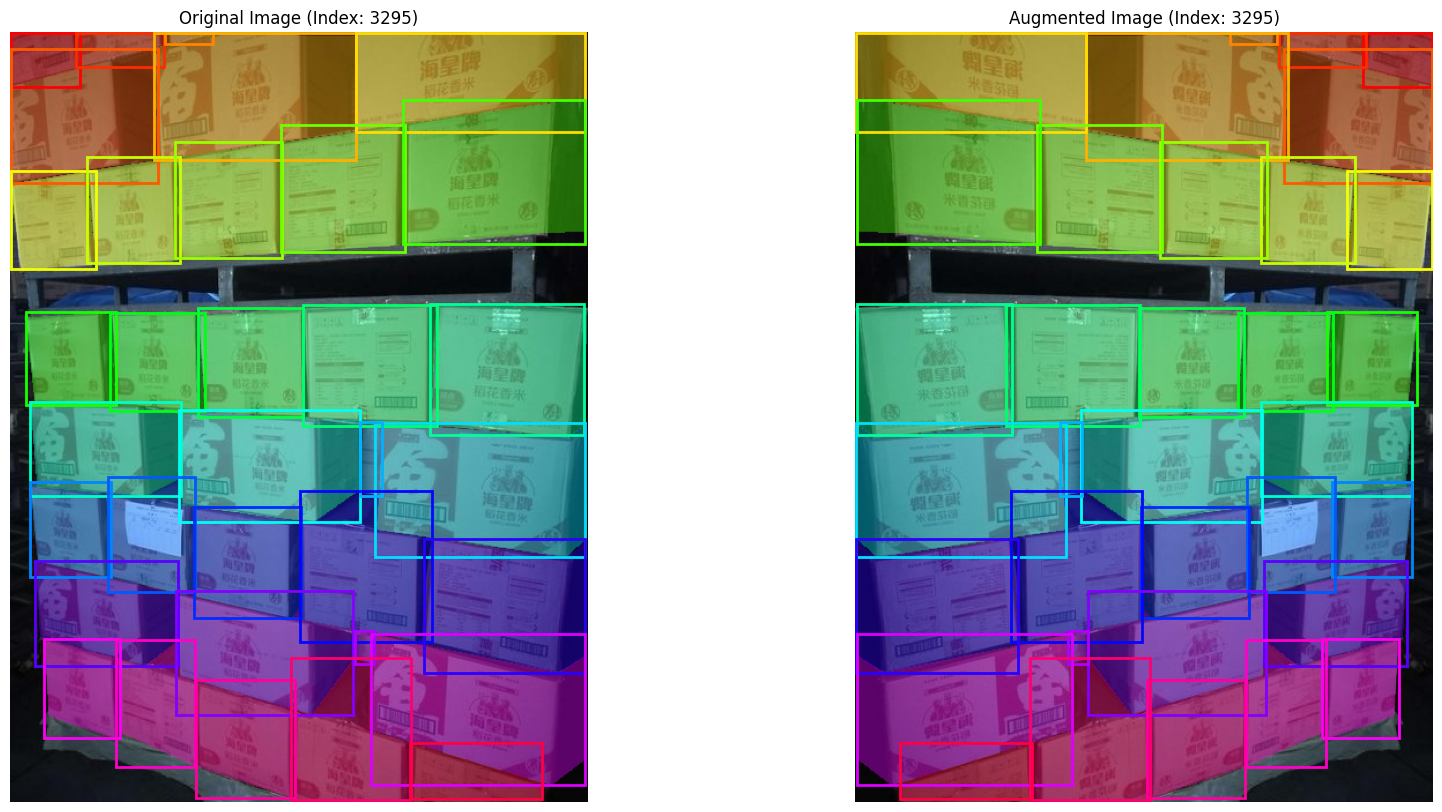

In [122]:
# Check the augmentation pipeline works as expected
sample_idx = random.randint(0, len(dataset) - 1)

img_pil_original, target_original = dataset[sample_idx]
img_original_np = np.array(img_pil_original)

img_augmented, masks_augmented_np, bboxes_augmented, category_ids_augmented = augmenter(img_pil_original, target_original)
img_augmented_np = img_augmented.permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plot_image_with_annotations(
    image_np=img_original_np,
    annotations=target_original,
    axis=axes[0],
    title=f"Original Image (Index: {sample_idx})",
    coco_api=getattr(dataset, 'coco', None)
)

target_augmented = convert_augmented_to_coco_format(
    masks_input=masks_augmented_np,
    bboxes_np=bboxes_augmented,
    category_ids=category_ids_augmented
)

plot_image_with_annotations(
    image_np=img_augmented_np,
    annotations=target_augmented, # Pass converted list[dict]
    axis=axes[1],
    title=f"Augmented Image (Index: {sample_idx})",
    coco_api=getattr(dataset, 'coco', None) # Pass coco API if available
)

In [123]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # Stack images if they are the same size, otherwise keep as list
    # Often images are resized to the same size before batching
    images = torch.stack(images, 0)
    return images, targets # targets remain a list of dicts/tensors


data_loader = DataLoader(dataset,
                         batch_size=4,
                         shuffle=True,
                         num_workers=0, # Set > 0 for parallel loading if needed (check OS compatibility)
                         collate_fn=custom_collate_fn) # Use custom collate_fn


In [124]:
print("\n--- DataLoader ---")
# Get one batch from the loader
try:
    first_batch = next(iter(data_loader))
    images_batch, targets_batch = first_batch

    print(f"Batch size: {len(images_batch)}")
    print(f"Type of images_batch: {type(images_batch)}") # Tuple of image tensors
    print(f"Type of targets_batch: {type(targets_batch)}") # Tuple of target lists
    print(f"Number of targets in first batch item: {len(targets_batch[0])}")
    print(f"Image tensor shape in batch (first image): {images_batch[0].shape}")
except Exception as e:
    print(f"Could not get batch from DataLoader: {e}")
    print("This might happen if the dataset is empty or paths are incorrect.")


--- DataLoader ---
Could not get batch from DataLoader: expected Tensor as element 0 in argument 0, but got Image
This might happen if the dataset is empty or paths are incorrect.
